# Forecasting power stats
### Maria Silva, May 2022

In this notebook, we use a simple model to forecast raw-byte power and quality-adjusted power. The code for the model can be found in the file `power_model.py`

In particular, we run the model with some dummy data to verify that the model is coded correctly and then we run 4 specific scenarios:

- **Base**: a scenario that uses current network stats (as of the end of May 2022) to set all user-defined model parameters. The idea is to simulate that the network continues to operate as it is doing now. In particular, we assume a constant level of new onboardings, Fil+ rates, and renewals equal to the current level observed. We also give some sensible estimates for the average sector durations.
- **Fil+ all-in**: a scenario almost equal to the base scenario, but where we assume an increase of Fil+ deals to a daily total of 5PiB. This is the goal communicated for Filecoin Plus.
- **Optimistic**: scenario that provides an optimist view of the base scenario. All the user-defined parameters increase when compared with the base scenario, and the Fil+ rate assumes the 5 PiB goal of the Fil+ all-in scenario.
- **Pessimistic**: scenario that provides a pessimistic view of the base scenario. Here, all user-defined parameters decrease. Renewals and onboardings are lower, and sector lengths are the minimum allowed. the Fil+ rate assumes a level of Fil+ onboarding equal to what we are seeing now.


Looking at the results, crossing the baseline does not seem an immediate concern for the network, which gives us time to study and analyze any potential change to baseline function.

In the base scenario, the network only goes below the baseline in May 2025. Even in the pessimistic scenario, the network only crosses the baseline in  November 2024. In other words, the rapid growth Filecoin experienced in 2021 made a nice cushion, which gives us some time to address a baseline crossing  event. 

## 1.  Modelling approach

Parameters (aka tunable user inputs):

* renewal_rate (%): sector renewal rate (out of scheduled expiration)
* rb_onboard_power (PiB): raw-byte storage amount to be onboarded on a daily basis
* fil_plus_rate (%): percentage of onboardPower that was made of Filcoin Plus deals
* onboard_length (days): length of the sectors onboarded
* renewal_length (days): length of the sectors renewed


Variables extracted from historic data:

* rb_power_zero (PiB): current total raw-byte power of the network
* qa_power_zero (PiB): current total quality-adjusted power of the network
* rb_known_scheduled_expire_vec (vector of PiB): raw-byte storage power from active sectors expected to expired at each day
* qa_known_scheduled_expire_vec (vector of PiB): raw-byte storage power from active sectors expected to expired at each day. Quick note here: at the moment, we do not have an easy way to collect this data and thus we will estimate ir based on the provided fil_plus_rate.

Additional documentation: [model spec](https://hackmd.io/@msilvaPL/H1uuNlItq)

## 2. Test model with dummy data

#### Imports

In [1]:
import os
import requests
import math
import numpy as np
import pandas as pd
import altair as alt
import warnings
import datetime
import power_model as p

warnings.filterwarnings('ignore')
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

#### Inputs

In [2]:
rb_power_zero = 10.0
qa_power_zero = 15.0
rb_known_scheduled_expire_vec = np.array([2, 2, 2])
qa_known_scheduled_expire_vec = np.array([3, 3, 3])

renewal_rate = 0.6
rb_onboard_power = 4
fil_plus_rate = 0.5
onboard_length = 3
renewal_length = 2
forecast_lenght = 8

#### Raw-byte Power

In [3]:
rb_onboarded_power_vec = p.forecast_rb_onboardings(rb_onboard_power, forecast_lenght)

rb_df = p.forecast_power_stats(
        rb_power_zero,
        rb_known_scheduled_expire_vec,
        rb_onboarded_power_vec,
        renewal_rate,
        onboard_length,
        renewal_length,
        forecast_lenght,
)

rb_df

,forecasting_step,onboarded_power,cum_onboarded_power,expired_power,cum_expired_power,total_power
0,0,0.0,0.0,0.80,0.80,9.20
1,1,4.0,4.0,0.80,1.60,12.40
2,2,4.0,8.0,1.28,2.88,15.12
3,3,4.0,12.0,0.48,3.36,18.64
4,4,4.0,16.0,2.08,5.44,20.56
5,5,4.0,20.0,1.60,7.04,22.96
6,6,4.0,24.0,2.56,9.60,24.40
7,7,4.0,28.0,2.56,12.16,25.84


#### Quality-adjusted Power

In [4]:
qa_onboarded_power_vec = p.forecast_qa_onboardings(rb_onboard_power, fil_plus_rate, forecast_lenght)

qa_df = p.forecast_power_stats(
        qa_power_zero,
        qa_known_scheduled_expire_vec,
        qa_onboarded_power_vec,
        renewal_rate,
        onboard_length,
        renewal_length,
        forecast_lenght,
)

qa_df

,forecasting_step,onboarded_power,cum_onboarded_power,expired_power,cum_expired_power,total_power
0,0,0.0,0.0,1.20,1.20,13.80
1,1,22.0,22.0,1.20,2.40,34.60
2,2,22.0,44.0,1.92,4.32,54.68
3,3,22.0,66.0,0.72,5.04,75.96
4,4,22.0,88.0,9.52,14.56,88.44
5,5,22.0,110.0,8.80,23.36,101.64
6,6,22.0,132.0,14.08,37.44,109.56
7,7,22.0,154.0,14.08,51.52,117.48


## 3. Run forecast for "base scenario"

- We will run the forecast for 4 years (forecast_lenght: 1460)
- Some user-defined paramaters have values equal to the ones observed at the end of May:
    - renewal_rate: 60%
    - rb_onboard_power: 27 PiB
    - fil_plus_rate: 800 TiB / rb_onboard_power * 1024 = 2.9%
- Other user-defined parameters get sensible estimates from expert judgement (will need to get empirical estimates for this eventually):
    - onboard_length: 10 months (300 days)
    - renewal_length: 1 year (365 days)
- Current network state variables are taken from the observed values on May 30st:
    - rb_power_zero: 16.34 EiB = 16.34 * 1024 PiB = 16732.16
    - qa_power_zero: 17.08 EiB = 17.08 * 1024 PiB = 17489.92
    - rb_known_scheduled_expire_vec: taken from the Starboard API. Note that for this we will exclude terminated sectors

#### Inputs

In [5]:
renewal_rate = 0.6
rb_onboard_power = 27.0
fil_plus_rate = 0.029
onboard_length = 300
renewal_length = 365
forecast_lenght = 1460

rb_power_zero = 16732.16
qa_power_zero = 17489.92

In [6]:
url = "https://observable-api.starboard.ventures/getdata/sectors_schedule_expiration_full?start=2020-01-01&end=2022-06-30"
r = requests.get(url)

# Put data in dataframe
scheduled_df = pd.DataFrame(r.json()["data"])

# Convert bytes to petabytes
pib_convertion = 2**50
scheduled_df["extended"] = scheduled_df["extended_bytes"].astype(float)/pib_convertion
scheduled_df["expired"] = scheduled_df["expired_bytes"].astype(float)/pib_convertion
scheduled_df["open"] = scheduled_df["potential_expire_bytes"].astype(float)/pib_convertion

# Total scheduled to expire, excluding 
scheduled_df["total"] = scheduled_df["extended"]+scheduled_df["expired"]+scheduled_df["open"]

# Convert interest date to datetime
scheduled_df["date"] = pd.to_datetime(scheduled_df["interest_date"])

# Filter past dates
scheduled_df = scheduled_df[scheduled_df["date"] > pd.Timestamp('2022-05-31T00:00:00.000000+0000')]

print(scheduled_df["date"].agg(["min", "max"]))

# Get array with the rb_known_scheduled_expire
rb_known_scheduled_expire_full_vec = scheduled_df["total"].values
rb_known_scheduled_expire_vec = rb_known_scheduled_expire_full_vec[:forecast_lenght]

len(rb_known_scheduled_expire_vec)

min   2022-06-01 00:00:00+00:00
max   2023-11-22 00:00:00+00:00
Name: date, dtype: datetime64[ns, UTC]


540

In [7]:
# Estimate qa_known_scheduled_expire_vec using the fil_plus_rate
qa_known_scheduled_expire_vec = (1 + 9 * fil_plus_rate) * rb_known_scheduled_expire_full_vec

In [8]:
# Baseline function
init_baseline = 2.88888888
baseline_growth = float(math.log(2)/365.0)

baseline_df = pd.DataFrame({
    "index": np.arange(forecast_lenght).astype("float"),
    "date": pd.date_range(start=pd.Timestamp('2022-05-31'), freq="d", periods=forecast_lenght),
})
baseline_df["total_power"] =  init_baseline * math.e**(baseline_growth*baseline_df["index"])
baseline_df["power_type"] = "baseline"
baseline_df = baseline_df[["date", "total_power", "power_type"]]

#### Run model

In [9]:
rb_onboarded_power_vec = p.forecast_rb_onboardings(rb_onboard_power, forecast_lenght)
rb_df = p.forecast_power_stats(
        rb_power_zero,
        rb_known_scheduled_expire_vec,
        rb_onboarded_power_vec,
        renewal_rate,
        onboard_length,
        renewal_length,
        forecast_lenght,
)
rb_df["power_type"] = "raw-byte"
rb_df["date"] = pd.date_range(start=pd.Timestamp('2022-05-31'), freq="d", periods=forecast_lenght)

qa_onboarded_power_vec = p.forecast_qa_onboardings(rb_onboard_power, fil_plus_rate, forecast_lenght)
qa_df = p.forecast_power_stats(
        qa_power_zero,
        qa_known_scheduled_expire_vec,
        qa_onboarded_power_vec,
        renewal_rate,
        onboard_length,
        renewal_length,
        forecast_lenght,
)
qa_df["power_type"] = "quality-adjusted"
qa_df["date"] = pd.date_range(start=pd.Timestamp('2022-05-31'), freq="d", periods=forecast_lenght)

df = pd.concat([rb_df, qa_df]).sort_values(["forecasting_step", "power_type"])
df.head()

,forecasting_step,onboarded_power,cum_onboarded_power,expired_power,cum_expired_power,total_power,power_type,date
0,0,0.000,0.000,10.576807,10.576807,17479.343193,quality-adjusted,2022-05-31
0,0,0.000,0.000,8.387634,8.387634,16723.772366,raw-byte,2022-05-31
1,1,34.047,34.047,12.003498,22.580305,17501.386695,quality-adjusted,2022-06-01
1,1,27.000,27.000,9.519031,17.906665,16741.253335,raw-byte,2022-06-01
2,2,34.047,68.094,26.685913,49.266217,17508.747783,quality-adjusted,2022-06-02


#### Plot results

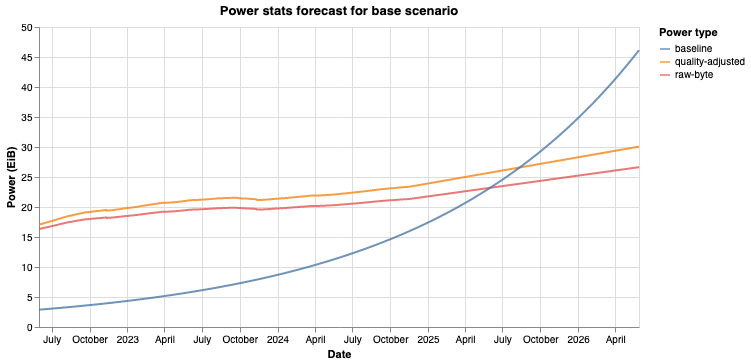

In [10]:
source = df[["date", "total_power", "power_type"]]
source["total_power"] = source["total_power"]/1024.0
source = pd.concat([source, baseline_df])

alt.Chart(source).mark_line(opacity=0.8).encode(
    x=alt.X('date:T', title="Date"),
    y=alt.Y('total_power:Q', title="Power (EiB)"),
    color=alt.Color('power_type:N', legend=alt.Legend(title="Power type"))
).properties(
    width=600, height=300, title="Power stats forecast for base scenario"
)

#### Save results

In [11]:
df.set_index(['date',"power_type"])['total_power'].unstack().to_csv("./scenarios/base.csv")

## 4. Run forecast for "Fil+ all-in scenario"

- We will run the forecast for 4 years (forecast_lenght: 1460)
- Onboarding user-defined paramaters assume the goal of 5PiB Fil+ onboarding per day:
    - renewal_rate: 60% (same)
    - rb_onboard_power: 31 PiB (current power plus a 4 PiB increase in Fil+)
    - fil_plus_rate: 5 PiB / rb_onboard_power = 16.1%
- Other user-defined parameters get sensible estimates from expert judgement (will need to get empirical estimates for this eventually):
    - onboard_length: 10 months (300 days)
    - renewal_length: 1 year (365 days)
- Current network state variables are taken from the observed values on May 30st:
    - rb_power_zero: 16.34 EiB = 16.34 * 1024 PiB = 16732.16
    - qa_power_zero: 17.08 EiB = 17.08 * 1024 PiB = 17489.92
    - rb_known_scheduled_expire_vec: taken from the Starboard API. Note that for this we will exclude terminated sectors

#### Inputs

In [12]:
renewal_rate = 0.6
rb_onboard_power = 31.0
fil_plus_rate = 0.161
onboard_length = 300
renewal_length = 365
forecast_lenght = 1460

rb_power_zero = 16732.16
qa_power_zero = 17489.92

#### Run model

In [13]:
rb_onboarded_power_vec = p.forecast_rb_onboardings(rb_onboard_power, forecast_lenght)
rb_df = p.forecast_power_stats(
        rb_power_zero,
        rb_known_scheduled_expire_vec,
        rb_onboarded_power_vec,
        renewal_rate,
        onboard_length,
        renewal_length,
        forecast_lenght,
)
rb_df["power_type"] = "raw-byte"
rb_df["date"] = pd.date_range(start=pd.Timestamp('2022-05-31'), freq="d", periods=forecast_lenght)

qa_onboarded_power_vec = p.forecast_qa_onboardings(rb_onboard_power, fil_plus_rate, forecast_lenght)
qa_df = p.forecast_power_stats(
        qa_power_zero,
        qa_known_scheduled_expire_vec,
        qa_onboarded_power_vec,
        renewal_rate,
        onboard_length,
        renewal_length,
        forecast_lenght,
)
qa_df["power_type"] = "quality-adjusted"
qa_df["date"] = pd.date_range(start=pd.Timestamp('2022-05-31'), freq="d", periods=forecast_lenght)

df = pd.concat([rb_df, qa_df]).sort_values(["forecasting_step", "power_type"])
df.head()

,forecasting_step,onboarded_power,cum_onboarded_power,expired_power,cum_expired_power,total_power,power_type,date
0,0,0.000,0.000,10.576807,10.576807,17479.343193,quality-adjusted,2022-05-31
0,0,0.000,0.000,8.387634,8.387634,16723.772366,raw-byte,2022-05-31
1,1,75.919,75.919,12.003498,22.580305,17543.258695,quality-adjusted,2022-06-01
1,1,31.000,31.000,9.519031,17.906665,16745.253335,raw-byte,2022-06-01
2,2,75.919,151.838,26.685913,49.266217,17592.491783,quality-adjusted,2022-06-02


#### Plot results

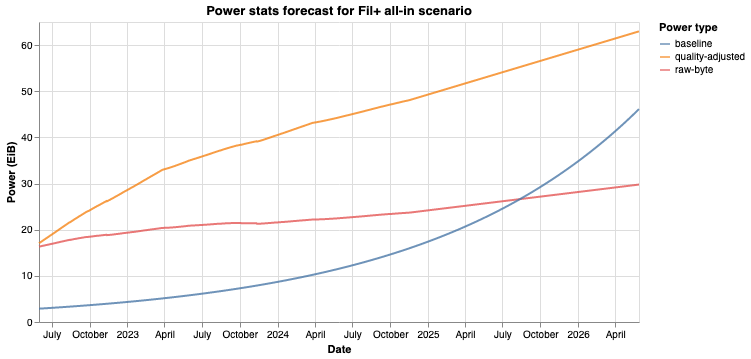

In [14]:
source = df[["date", "total_power", "power_type"]]
source["total_power"] = source["total_power"]/1024.0
source = pd.concat([source, baseline_df])

alt.Chart(source).mark_line(opacity=0.8).encode(
    x=alt.X('date:T', title="Date"),
    y=alt.Y('total_power:Q', title="Power (EiB)"),
    color=alt.Color('power_type:N', legend=alt.Legend(title="Power type"))
).properties(
    width=600, height=300, title="Power stats forecast for Fil+ all-in scenario"
)

#### Save results

In [15]:
df.set_index(['date',"power_type"])['total_power'].to_csv("./scenarios/fil_plus_all_in.csv")

## 5. Run forecast for "optimistic scenario"

- We will run the forecast for 4 years (forecast_lenght: 1460)
- User-defined paramaters have more optimistic values:
    - renewal_rate: 80% (increased renewals)
    - rb_onboard_power: 35 PiB (a 30% increase from current values)
    - fil_plus_rate: 5 PiB / rb_onboard_power = 14.2% (still maintaining the fil+ goal)
    - onboard_length: 18 months (540 days) -> longer than baseline
    - renewal_length: 2 year (730 days) -> longer than baseline
- Current network state variables are taken from the observed values on May 30st:
    - rb_power_zero: 16.34 EiB = 16.34 * 1024 PiB = 16732.16
    - qa_power_zero: 17.08 EiB = 17.08 * 1024 PiB = 17489.92
    - rb_known_scheduled_expire_vec: taken from the Starboard API. Note that for this we will exclude terminated sectors

#### Inputs

In [16]:
renewal_rate = 0.8
rb_onboard_power = 35.0
fil_plus_rate = 0.142
onboard_length = 540
renewal_length = 730
forecast_lenght = 1460

rb_power_zero = 16732.16
qa_power_zero = 17489.92

#### Run model

In [17]:
rb_onboarded_power_vec = p.forecast_rb_onboardings(rb_onboard_power, forecast_lenght)
rb_df = p.forecast_power_stats(
        rb_power_zero,
        rb_known_scheduled_expire_vec,
        rb_onboarded_power_vec,
        renewal_rate,
        onboard_length,
        renewal_length,
        forecast_lenght,
)
rb_df["power_type"] = "raw-byte"
rb_df["date"] = pd.date_range(start=pd.Timestamp('2022-05-31'), freq="d", periods=forecast_lenght)

qa_onboarded_power_vec = p.forecast_qa_onboardings(rb_onboard_power, fil_plus_rate, forecast_lenght)
qa_df = p.forecast_power_stats(
        qa_power_zero,
        qa_known_scheduled_expire_vec,
        qa_onboarded_power_vec,
        renewal_rate,
        onboard_length,
        renewal_length,
        forecast_lenght,
)
qa_df["power_type"] = "quality-adjusted"
qa_df["date"] = pd.date_range(start=pd.Timestamp('2022-05-31'), freq="d", periods=forecast_lenght)

df = pd.concat([rb_df, qa_df]).sort_values(["forecasting_step", "power_type"])
df.head()

,forecasting_step,onboarded_power,cum_onboarded_power,expired_power,cum_expired_power,total_power,power_type,date
0,0,0.00,0.00,5.288403,5.288403,17484.631597,quality-adjusted,2022-05-31
0,0,0.00,0.00,4.193817,4.193817,16727.966183,raw-byte,2022-05-31
1,1,79.73,79.73,6.001749,11.290152,17558.359848,quality-adjusted,2022-06-01
1,1,35.00,35.00,4.759515,8.953333,16758.206667,raw-byte,2022-06-01
2,2,79.73,159.46,13.342956,24.633109,17624.746891,quality-adjusted,2022-06-02


#### Plot results

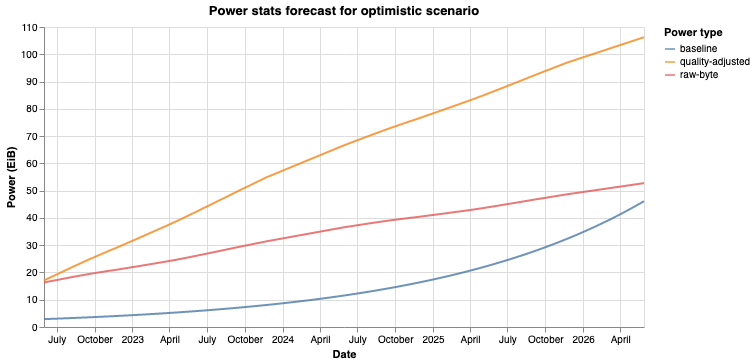

In [18]:
source = df[["date", "total_power", "power_type"]]
source["total_power"] = source["total_power"]/1024.0
source = pd.concat([source, baseline_df])

alt.Chart(source).mark_line(opacity=0.8).encode(
    x=alt.X('date:T', title="Date"),
    y=alt.Y('total_power:Q', title="Power (EiB)"),
    color=alt.Color('power_type:N', legend=alt.Legend(title="Power type"))
).properties(
    width=600, height=300, title="Power stats forecast for optimistic scenario"
)

#### Save results

In [19]:
df.set_index(['date',"power_type"])['total_power'].to_csv("./scenarios/optimistc.csv")

## 6. Run forecast for "pessimistic scenario"

- We will run the forecast for 4 years (forecast_lenght: 1460)
- User-defined paramaters have more pessimistic values:
    - renewal_rate: 40% (lower level of renewals)
    - rb_onboard_power: 24 PiB (10% decrease in onboardings)
    - fil_plus_rate: 800 TiB / rb_onboard_power * 1024 = 3.2% (same value as current)
    - onboard_length: 6 months (180 days) -> minimum allowed
    - renewal_length: 6 months (180 days) -> minimum allowed
- Current network state variables are taken from the observed values on May 30st:
    - rb_power_zero: 16.34 EiB = 16.34 * 1024 PiB = 16732.16
    - qa_power_zero: 17.08 EiB = 17.08 * 1024 PiB = 17489.92
    - rb_known_scheduled_expire_vec: taken from the Starboard API. Note that for this we will exclude terminated sectors

#### Inputs

In [20]:
renewal_rate = 0.4
rb_onboard_power = 24.0
fil_plus_rate = 0.032
onboard_length = 180
renewal_length = 180
forecast_lenght = 1460

rb_power_zero = 16732.16
qa_power_zero = 17489.92

#### Run model

In [21]:
rb_onboarded_power_vec = p.forecast_rb_onboardings(rb_onboard_power, forecast_lenght)
rb_df = p.forecast_power_stats(
        rb_power_zero,
        rb_known_scheduled_expire_vec,
        rb_onboarded_power_vec,
        renewal_rate,
        onboard_length,
        renewal_length,
        forecast_lenght,
)
rb_df["power_type"] = "raw-byte"
rb_df["date"] = pd.date_range(start=pd.Timestamp('2022-05-31'), freq="d", periods=forecast_lenght)

qa_onboarded_power_vec = p.forecast_qa_onboardings(rb_onboard_power, fil_plus_rate, forecast_lenght)
qa_df = p.forecast_power_stats(
        qa_power_zero,
        qa_known_scheduled_expire_vec,
        qa_onboarded_power_vec,
        renewal_rate,
        onboard_length,
        renewal_length,
        forecast_lenght,
)
qa_df["power_type"] = "quality-adjusted"
qa_df["date"] = pd.date_range(start=pd.Timestamp('2022-05-31'), freq="d", periods=forecast_lenght)

df = pd.concat([rb_df, qa_df]).sort_values(["forecasting_step", "power_type"])
df.head()

,forecasting_step,onboarded_power,cum_onboarded_power,expired_power,cum_expired_power,total_power,power_type,date
0,0,0.000,0.000,15.865210,15.865210,17474.054790,quality-adjusted,2022-05-31
0,0,0.000,0.000,12.581451,12.581451,16719.578549,raw-byte,2022-05-31
1,1,30.912,30.912,18.005247,33.870457,17486.961543,quality-adjusted,2022-06-01
1,1,24.000,24.000,14.278546,26.859998,16729.300002,raw-byte,2022-06-01
2,2,30.912,61.824,40.028869,73.899326,17477.844674,quality-adjusted,2022-06-02


#### Plot results

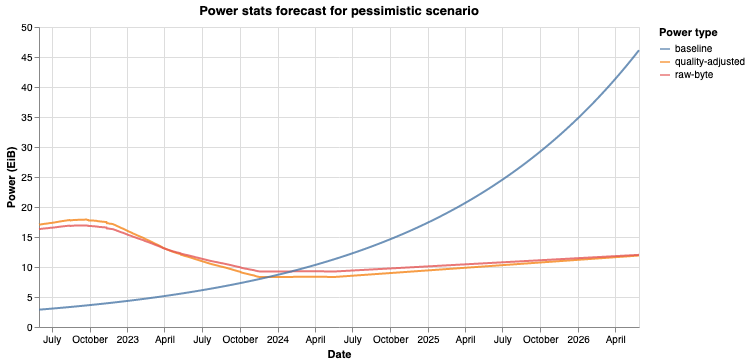

In [22]:
source = df[["date", "total_power", "power_type"]]
source["total_power"] = source["total_power"]/1024.0
source = pd.concat([source, baseline_df])

alt.Chart(source).mark_line(opacity=0.8).encode(
    x=alt.X('date:T', title="Date"),
    y=alt.Y('total_power:Q', title="Power (EiB)"),
    color=alt.Color('power_type:N', legend=alt.Legend(title="Power type"))
).properties(
    width=600, height=300, title="Power stats forecast for pessimistic scenario"
)

#### Save results

In [23]:
df.set_index(['date',"power_type"])['total_power'].to_csv("./scenarios/pessimistic.csv")